In [16]:
import csv
import time

import alphashape
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from swimpde.ansatz import BasicAnsatz
from swimpde.boundary import Dirichlet
from swimpde.domain import Domain
from swimpde.solver import StaticSolver

# from utils import compute_metrics

In [17]:
a_ratio = 8.8131
Cv = 75.2629
theta_fiber = 0
theta0 = np.pi/2 - theta_fiber
a = np.array([np.cos(theta0), np.sin(theta0)]).T
b = np.array([np.cos(theta0-np.pi/2), np.sin(theta0-np.pi/2)]).T
D = ( (1/a_ratio)*np.tensordot( a, a,  axes=0) + np.tensordot( b, b,  axes=0)  )

In [18]:
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from swimpde.abstract import Ansatz, StaticEquation

@dataclass
class EikonalAnisotropic(StaticEquation):
    """
    Eikonal anisotropa:
        Cv² * (∇uᵀ D ∇u) - 1 = 0
    """
    D: npt.ArrayLike  # Matrice 2x2
    Cv: float         # Velocità

    def equation_operator(self, ansatz: Ansatz, points: npt.ArrayLike) -> npt.ArrayLike:
        grad_u = ansatz.transform(points, operator="grad")  # (N, 2)
        grad_D_grad = np.einsum("ni,ij,nj->n", grad_u, self.D, grad_u)  # ∇uᵀ D ∇u
        return self.Cv**2 * grad_D_grad - 1

    def equation_bias(self) -> float:
        return 0.0

Parameters of the equation

In [19]:
# def forcing(x: npt.ArrayLike):
#     scales = np.array([1, 1, 4])
#     sin_transforms = np.sin(np.pi * scales * x)
#     u = 5 + np.prod(sin_transforms, axis=1)[:, None]
#     u_xx = -18 * np.pi**2 * (u - 5)
#     return u_xx - u

# def solution(x: npt.ArrayLike) -> npt.ArrayLike:
#     scales = np.array([1, 1, 4])
#     sin_transforms = np.sin(np.pi * scales * x)
#     return 5 + np.prod(sin_transforms, axis=1)[:, None]

# boundary_condition = Dirichlet(solution)

Load the data

In [20]:
# # Load the bunny points.
# with open('data/bunny_vertices.csv') as fin:
#     csvreader = csv.reader(fin)
#     bunny_points = np.array(list(csvreader)).astype(float)

# # Create alpha shape
# alpha = 1e-4
# alpha_shape = alphashape.alphashape(bunny_points, alpha)

# # shape: (n_points, n_vertices)
# vertices_mask = np.all(bunny_points[:, None, :] ==
#                        alpha_shape.vertices[None, :, :],
#                        axis=-1)
# if (np.any(vertices_mask.sum(axis=0) != 1) or
#     np.any(vertices_mask.sum(axis=1) > 1)):
#     raise ValueError("Something went wrong with the mask.")

# boundary_mask = np.any(vertices_mask, axis=1)
# interior_points = bunny_points[~boundary_mask]
# boundary_points = bunny_points[boundary_mask]

# # Visualize the data
# fig = plt.figure()
# ax_int = fig.add_subplot(121, projection='3d')
# ax_int.scatter(*interior_points.T)
# ax_int.set_title("interior")

# ax_bound = fig.add_subplot(122, projection='3d')
# ax_bound.scatter(*boundary_points.T, c='r')
# ax_bound.set_title("boundary");

Create a train/test split

In [21]:
# rng = np.random.default_rng(42)
# train_fraction = 0.7

# def get_train_mask(rng: np.random.Generator,
#                    n_points: int,
#                    train_fraction: float):
#     mask = np.zeros(n_points).astype(bool)
#     train_indices = rng.choice(n_points,
#                                size=int(n_points*train_fraction),
#                                replace=False)
#     mask[train_indices] = True
#     return mask
    
# interior_train_mask = get_train_mask(rng,
#                                      interior_points.shape[0],
#                                      train_fraction)
# boundary_train_mask = get_train_mask(rng,
#                                      boundary_points.shape[0],
#                                      train_fraction)

# train_interior = interior_points[interior_train_mask]
# test_interior = interior_points[~interior_train_mask]
# train_boundary = boundary_points[boundary_train_mask]
# test_boundary = boundary_points[~boundary_train_mask]

In [22]:
# Evaluation data to test the results on.
n_test_sqrt = 101
x_span = -2, 2
n_dim = 2

x_test = np.linspace(*x_span, num=n_test_sqrt)
y_test = np.linspace(*x_span, num=n_test_sqrt)
xy_test = np.stack(np.meshgrid(x_test, y_test), axis=-1)
xy_test = xy_test.reshape(-1, n_dim)

from Eikonal_groundtruth import *
u_test = anysotropic_FMM_fast(x0, y0, t0, x1, y1, t1, Cv, r)

In [23]:
# Measurement points to use for training.
n_measurement_points = 20

u_measured = np.load("datasets/recordedtimes.npy").reshape(-1, 1)
xy_measurement = np.load("datasets/locations.npy")

Create data for evaluation

In [24]:
# Create the domain
domain = Domain(interior_points=xy_measurement)

Solve the equation

In [25]:
# Parameters of the solver 
n_basis = 2000
activation = "tanh"
random_seed = 42
svd_cutoff = 1e-12
regularization_scale = 1e-12

In [26]:
# Define the domain.
domain = Domain(interior_points=xy_measurement)

# Define the basic ansatz.
ansatz = BasicAnsatz(
    n_basis=n_basis,
    activation=activation,
    random_seed=random_seed,
    svd_cutoff=svd_cutoff,
)

# Define the equation.
equation = EikonalAnisotropic(D, Cv)

# Define the solver.
solver = StaticSolver(
    domain=domain,
    boundary_condition=None,
    equation=equation,
    ansatz=ansatz,
    f=1,
    regularization_scale=regularization_scale,
)

# Fir the solver.
start_fit = time.time()
solver.fit()
end_fit = time.time()
training_time = end_fit - start_fit

print(f"Training time: {training_time:.4f}s")

TypeError: 'int' object is not callable

Evaluate the solver

Relative error: 2.813E-03


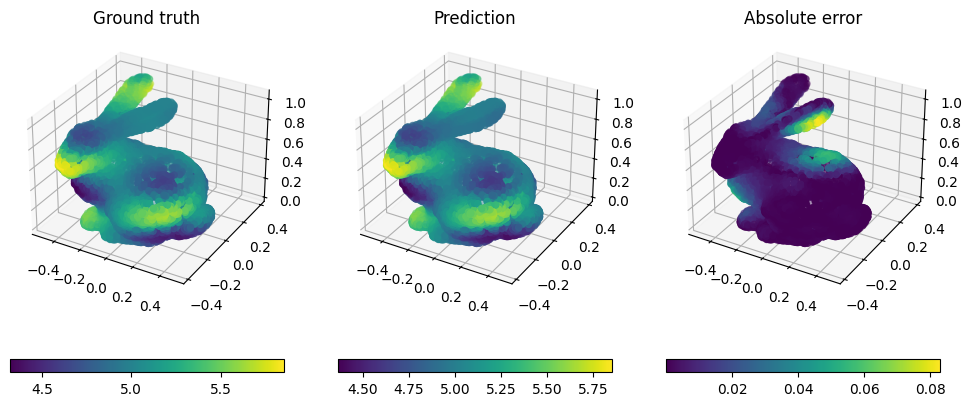

In [ ]:
u_pred = solver.evaluate(xy_test)
abs_error, rel_l2_error = compute_metrics(u_pred, u_exact)

print(fr"Relative error: {rel_l2_error:.3E}")

data = {"Ground truth": u_exact,
        "Prediction": u_pred,
        "Absolute error": abs_error}

fig = plt.figure(figsize=(12, 5))
for i, label in enumerate(data):
    ax = fig.add_subplot(1, 3, i+1, projection="3d")
    sc = ax.scatter(*x_eval.T, c=data[label])
    fig.colorbar(sc, ax=ax, location='bottom')
    ax.set_title(label)